In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import aesara as ae
import aesara.tensor as T
import pytensor.tensor as pt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,LabelBinarizer
import pickle
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Stack 50 assays together along with assay meta info

In [9]:
xls = pd.ExcelFile('assay_list.xls')

# Now you can list all sheets in the file
xls.sheet_names

# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)

34

In [10]:
xls2 = pd.ExcelFile('assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)

50

In [17]:
protocols = [df[i].columns[1] for i in range(len(df))]
print(len(protocols))
protocols

50


['tox21-ahr-p1',
 'tox21-ap1-agonist-p1',
 'tox21-ar-bla-antagonist-p1',
 'tox21-ar-mda-kb2-luc-agonist-p3',
 'tox21-ar-mda-kb2-luc-antagonist-p1',
 'tox21-ar-mda-kb2-luc-antagonist-p2',
 'tox21-are-bla-p1',
 'tox21-aromatase-p1',
 'tox21-car-agonist-p1',
 'tox21-car-antagonist-p1',
 'tox21-elg1-luc-agonist-p1',
 'tox21-er-bla-antagonist-p1',
 'tox21-er-luc-bg1-4e2-agonist-p4',
 'tox21-er-luc-bg1-4e2-antagonist-p1',
 'tox21-er-luc-bg1-4e2-antagonist-p2',
 'tox21-erb-bla-antagonist-p1',
 'tox21-erb-bla-p1',
 'tox21-err-p1',
 'tox21-esre-bla-p1',
 'tox21-fxr-bla-agonist-p2',
 'tox21-fxr-bla-antagonist-p1',
 'tox21-gh3-tre-antagonist-p1',
 'tox21-gr-hela-bla-antagonist-p1',
 'tox21-h2ax-cho-p2',
 'tox21-hdac-p1',
 'tox21-hre-bla-agonist-p1',
 'tox21-hse-bla-p1',
 'tox21-mitotox-p1',
 'tox21-nfkb-bla-agonist-p1',
 'tox21-p53-bla-p1',
 'tox21-pgc-err-p1',
 'tox21-ppard-bla-agonist-p1',
 'tox21-ppard-bla-antagonist-p1',
 'tox21-pparg-bla-antagonist-p1',
 'tox21-pr-bla-agonist-p1',
 'tox21-pr

In [2]:
t = pd.DataFrame({'Cell_Line': ['DT40','DT40', 'DT40'], 'ProtocolName':['tox21-dt40-p1_100', 'tox21-dt40-p1_653', 'tox21-dt40-p1_657']})

In [20]:
assay_info_tox21 = pd.read_csv('assay_meta_data.csv')
assay_info_tox21 = assay_info_tox21.drop(assay_info_tox21.columns[0], axis = 1)
assay_info_tox21['Cell_Line'] = assay_info_tox21['Cell_Line'].str.replace(r'*', '', regex=True)
assay_info_tox21 = assay_info_tox21[['Cell_Line', 'ProtocolName']]

assay_info_tox21 = assay_info_tox21.drop([49])
assay_info_tox21 = pd.concat([assay_info_tox21, t]).reset_index(drop=True)
assay_info_tox21

,Cell_Line,ProtocolName
0,HepG2,tox21-ahr-p1
1,HepG2,tox21-are-bla-p1
2,HepG2,tox21-car-agonist-p1
3,HepG2,tox21-car-antagonist-p1
4,HepG2,tox21-casp3-hepg2-p1
...,...,...
64,NIH/3T3,tox21-shh-3t3-gli3-agonist-p1
65,NIH/3T3,tox21-shh-3t3-gli3-antagonist-p1
66,DT40,tox21-dt40-p1_100
67,DT40,tox21-dt40-p1_653


In [22]:
assay_info = pd.read_excel('SampleMeta_Data_update.xlsx')
assay_info = assay_info.drop(assay_info.columns[6:], axis=1).iloc[:13,:].rename(columns = {assay_info.columns[5]: 'Tissue_Type2'})
assay_info['Cell_Line'] = assay_info['Cell_Line'].str.replace(r'*', '', regex=True).str.replace(' ', '')
assay_info['Cell_Type'] = assay_info['Cell_Type'].str.replace(r'*', '', regex=True)
assay_info = assay_info.join(assay_info_tox21.set_index('Cell_Line'), on='Cell_Line')
assay_info = assay_info[assay_info.ProtocolName.isin(protocols)].reset_index(drop=True)
assay_info

,Cell_Line,Tissue_Type4,Cell_Type,Gender,Organism,Tissue_Type2,ProtocolName
0,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion,tox21-ar-mda-kb2-luc-agonist-p3
1,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion,tox21-ar-mda-kb2-luc-antagonist-p1
2,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion,tox21-ar-mda-kb2-luc-antagonist-p2
3,MCF-7,Primary,epithelial,F,Human,mammary gland,tox21-aromatase-p1
4,DT40,Primary,lymphoblast,F,Animal cell,bursa,tox21-dt40-p1_100
5,DT40,Primary,lymphoblast,F,Animal cell,bursa,tox21-dt40-p1_653
6,DT40,Primary,lymphoblast,F,Animal cell,bursa,tox21-dt40-p1_657
7,NIH/3T3,Normal,fibroblast,M,Animal cell,connective tissue,tox21-shh-3t3-gli3-agonist-p1
8,NIH/3T3,Normal,fibroblast,M,Animal cell,connective tissue,tox21-shh-3t3-gli3-antagonist-p1
9,C3H10T1/2,Normal,fibroblast,F,Animal cell,connective tissue,tox21-rar-antagonist-p2


In [23]:
assay_info.to_csv('50_assay_meta_info.csv', index=False)

In [30]:
assay_idx = [6,7,8,9,28,29,30,31]
meta_idx = [3,4,6]
assay_info = assay_info.reset_index(drop=True).iloc[assay_idx,meta_idx]

In [7]:
# data_process for one assay before combining the assay meta info
# could delete for script
one_assay = df[0]
one_assay = one_assay.drop(one_assay.columns[0], axis=1).drop_duplicates()
one_assay['ProtocolName'] = one_assay.columns[0]
one_assay = one_assay.rename(columns = {one_assay.columns[0]: 'Outcome'})
one_assay

,Outcome,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,ProtocolName
0,1,[Br-].CCCCCCCCCCCCCC[n+]1ccccc1,2.287998,0.000000,2.287998,0.000000,0.377974,356.392,322.120,355.187462,...,0,0,0,0,0,0,0,10,0,tox21-ahr-p1
1,0,C[C@]12CC[C@H](C[C@H]1O)C2(C)C,9.814236,-0.031250,9.814236,0.031250,0.566800,154.253,136.109,154.135765,...,0,0,0,0,0,0,0,0,0,tox21-ahr-p1
2,0,CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC,2.473380,0.534907,2.473380,0.534907,0.689255,255.405,230.205,255.198700,...,0,0,0,0,0,0,0,0,0,tox21-ahr-p1
3,0,OCC(=O)OCCCC,10.214402,-0.538472,10.214402,0.426481,0.442392,132.159,120.063,132.078644,...,0,0,0,0,0,0,0,1,0,tox21-ahr-p1
4,0,Nc1ccc(cc1)C(=O)OCC,11.092937,-0.307870,11.092937,0.307870,0.532618,165.192,154.104,165.078979,...,0,0,0,0,0,0,0,0,0,tox21-ahr-p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9677,0,Clc1ccc(OCC(O)COC(N)=O)cc1,10.248885,-0.925423,10.248885,0.008842,0.816060,245.662,233.566,245.045486,...,0,0,0,0,0,0,0,0,0,tox21-ahr-p1
9679,0,O=S(=O)(O)O.C[C@@H](CC)CCCCC(=O)N[C@@H](CCN)C(...,14.424310,-4.666667,14.424310,0.013058,0.024478,1267.561,1164.745,1266.732957,...,0,0,0,0,0,0,0,1,0,tox21-ahr-p1
9680,0,Cl.O=S(N)(=O)c1ccc(CN)cc1,10.779027,-3.568620,10.779027,0.000000,0.750448,222.697,211.609,222.022976,...,1,0,0,0,0,0,0,0,0,tox21-ahr-p1
9681,0,Oc1cc(cc(O)c1)C(O)CNC(C)C.O=S(=O)(O)O.CC(C)NCC...,9.733565,-4.666667,9.733565,0.047595,0.224312,520.601,484.313,520.209066,...,0,0,0,0,0,0,0,0,0,tox21-ahr-p1


In [26]:
df_list = []
for i in range(len(df)):
    one_assay = df[i]
    one_assay = one_assay.drop(one_assay.columns[0], axis=1).drop_duplicates()
    one_assay['ProtocolName'] = one_assay.columns[0]
    one_assay = one_assay.rename(columns = {one_assay.columns[0]: 'Outcome'})
    df_list.append(one_assay)
    
len(df_list)

50

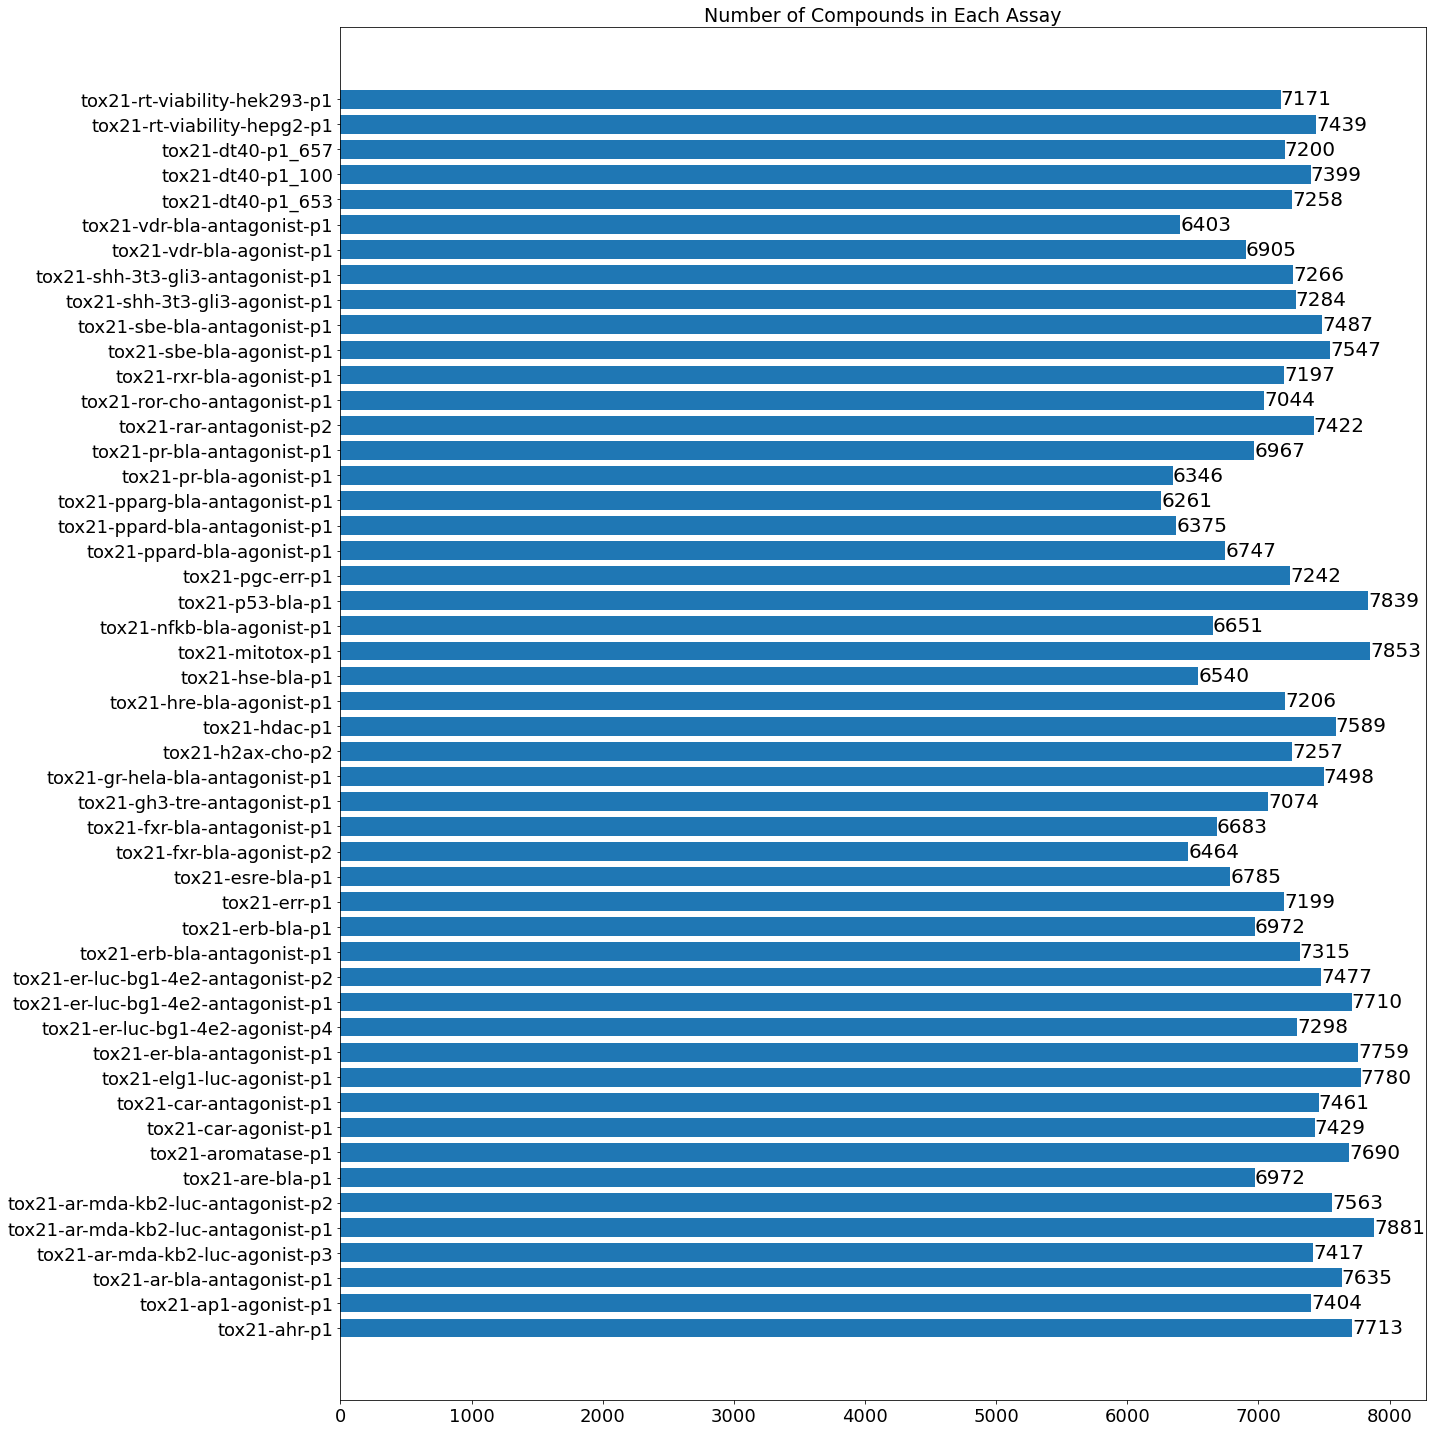

In [60]:
fig, ax = plt.subplots(figsize=(20,20))
num_cpd = []
names = []
for i in range(len(df_list)):
    n = len(df_list[i])
    name = df_list[i].ProtocolName[0]
    num_cpd.append(n)
    names.append(name)

bars = ax.barh(y = names, width = num_cpd, height = 0.75)
ax.bar_label(bars, fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Number of Compounds in Each Assay', fontsize=19)
fig.tight_layout()
# plt.show()

In [10]:
df_all = df_list[0].loc[:,df_list[0].apply(pd.Series.nunique) != 1]

    # replace all infinity values with nan
df_all = df_all.replace([np.inf, -np.inf], np.nan)

    # remove columns with above .15 empty cells
thresh = len(df_all) * .15
df_all.dropna(thresh = thresh, axis = 1, inplace = True)

    # replace all empty cells with mean of columns
column_means = df_all.mean()
df_all = df_all.fillna(column_means)
df_all

/var/folders/mw/vsqjplld57v73jz2c0hw5x00llg6y6/T/ipykernel_69194/1375106453.py:11: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  column_means = df_all.mean()


,Outcome,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,[Br-].CCCCCCCCCCCCCC[n+]1ccccc1,2.287998,0.000000,2.287998,0.000000,0.377974,356.392,322.120,355.187462,...,0,0,0,0,0,0,0,0,10,0
1,0,C[C@]12CC[C@H](C[C@H]1O)C2(C)C,9.814236,-0.031250,9.814236,0.031250,0.566800,154.253,136.109,154.135765,...,0,0,0,0,0,0,0,0,0,0
2,0,CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC,2.473380,0.534907,2.473380,0.534907,0.689255,255.405,230.205,255.198700,...,0,0,0,0,0,0,0,0,0,0
3,0,OCC(=O)OCCCC,10.214402,-0.538472,10.214402,0.426481,0.442392,132.159,120.063,132.078644,...,0,0,0,0,0,0,0,0,1,0
4,0,Nc1ccc(cc1)C(=O)OCC,11.092937,-0.307870,11.092937,0.307870,0.532618,165.192,154.104,165.078979,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9677,0,Clc1ccc(OCC(O)COC(N)=O)cc1,10.248885,-0.925423,10.248885,0.008842,0.816060,245.662,233.566,245.045486,...,0,0,0,0,0,0,0,0,0,0
9679,0,O=S(=O)(O)O.C[C@@H](CC)CCCCC(=O)N[C@@H](CCN)C(...,14.424310,-4.666667,14.424310,0.013058,0.024478,1267.561,1164.745,1266.732957,...,0,0,0,0,0,0,0,0,1,0
9680,0,Cl.O=S(N)(=O)c1ccc(CN)cc1,10.779027,-3.568620,10.779027,0.000000,0.750448,222.697,211.609,222.022976,...,0,1,0,0,0,0,0,0,0,0
9681,0,Oc1cc(cc(O)c1)C(O)CNC(C)C.O=S(=O)(O)O.CC(C)NCC...,9.733565,-4.666667,9.733565,0.047595,0.224312,520.601,484.313,520.209066,...,0,0,0,0,0,0,0,0,0,0


In [34]:
assay_info

,Gender,Organism,ProtocolName
6,F,Animal cell,tox21-dt40-p1_657
7,M,Animal cell,tox21-shh-3t3-gli3-agonist-p1
8,M,Animal cell,tox21-shh-3t3-gli3-antagonist-p1
9,F,Animal cell,tox21-rar-antagonist-p2
28,F,Human,tox21-vdr-bla-agonist-p1
29,F,Human,tox21-vdr-bla-antagonist-p1
30,M,Human,tox21-hdac-p1
31,M,Human,tox21-p53-bla-p1


In [35]:
df_stack_50 = pd.concat(df_list)
df_stack_50 = df_stack_50.join(assay_info.set_index('ProtocolName'), on='ProtocolName')
df_stack_50 = df_stack_50[df_stack_50.ProtocolName.isin(assay_info.ProtocolName)]
df_stack_50

,Outcome,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,ProtocolName,Gender,Organism
0,0,[Br-].CCCCCCCCCCCCCC[n+]1ccccc1,2.287998,0.000000,2.287998,0.000000,0.377974,356.392,322.120,355.187462,...,0,0,0,0,0,10,0,tox21-hdac-p1,M,Human
1,0,C[C@]12CC[C@H](C[C@H]1O)C2(C)C,9.814236,-0.031250,9.814236,0.031250,0.566800,154.253,136.109,154.135765,...,0,0,0,0,0,0,0,tox21-hdac-p1,M,Human
2,0,CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC,2.473380,0.534907,2.473380,0.534907,0.689255,255.405,230.205,255.198700,...,0,0,0,0,0,0,0,tox21-hdac-p1,M,Human
3,0,OCC(=O)OCCCC,10.214402,-0.538472,10.214402,0.426481,0.442392,132.159,120.063,132.078644,...,0,0,0,0,0,1,0,tox21-hdac-p1,M,Human
4,0,Nc1ccc(cc1)C(=O)OCC,11.092937,-0.307870,11.092937,0.307870,0.532618,165.192,154.104,165.078979,...,0,0,0,0,0,0,0,tox21-hdac-p1,M,Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,0,Brc2c3nccnc3ccc2NC1=NCCN1,4.306315,0.799945,4.306315,0.799945,0.840528,292.140,282.060,291.011957,...,0,0,0,0,0,0,0,tox21-dt40-p1_657,F,Animal cell
8688,0,Clc1ccc(OCC(O)COC(N)=O)cc1,10.248885,-0.925423,10.248885,0.008842,0.816060,245.662,233.566,245.045486,...,0,0,0,0,0,0,0,tox21-dt40-p1_657,F,Animal cell
8690,0,Cl.O=S(N)(=O)c1ccc(CN)cc1,10.779027,-3.568620,10.779027,0.000000,0.750448,222.697,211.609,222.022976,...,0,0,0,0,0,0,0,tox21-dt40-p1_657,F,Animal cell
8691,0,Oc1cc(cc(O)c1)C(O)CNC(C)C.O=S(=O)(O)O.CC(C)NCC...,9.733565,-4.666667,9.733565,0.047595,0.224312,520.601,484.313,520.209066,...,0,0,0,0,0,0,0,tox21-dt40-p1_657,F,Animal cell


### Train/Test Split & Bayesian model coordination

In [36]:
df_stack_50.Outcome = df_stack_50.Outcome.astype(object)
df_stack_50.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,...,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.000000,57908.00000,57908.000000
mean,9.653646,-0.905269,9.655983,0.306816,0.534669,268.732801,251.654993,268.315771,96.852283,0.004248,...,0.035833,0.036817,0.007305,0.005198,0.003678,0.013021,0.001900,0.010448,0.65813,0.027509
std,3.123907,1.702865,3.124361,0.453759,0.185705,154.156860,146.103629,153.971063,55.965975,0.078293,...,0.211840,0.219088,0.088731,0.072626,0.061668,0.119012,0.046608,0.111559,2.29657,0.176463
min,0.000000,-10.657407,0.000000,0.000000,0.010404,30.026000,28.010000,30.010565,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,8.387206,-1.231536,8.387206,0.035278,0.414601,162.381000,151.597000,162.092376,58.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,10.508845,-0.429398,10.526627,0.154736,0.537484,233.699000,219.772500,233.112404,84.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,11.846682,0.040035,11.846682,0.392917,0.669301,337.628000,316.197750,337.243936,122.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,17.442653,2.120000,17.442653,8.764932,0.944994,1950.681000,1904.313000,1949.500417,704.000000,3.000000,...,4.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,3.000000,72.00000,4.000000


In [37]:
numeric_columns=list(df_stack_50.select_dtypes(['float64', 'int64']).columns)
categorical_columns=list(df_stack_50.select_dtypes('object').columns)
print(len(numeric_columns))

pipeline=ColumnTransformer([
    ('num',StandardScaler(),numeric_columns),
    ('cat', 'passthrough', categorical_columns)])

chem_des_scale = pipeline.fit_transform(df_stack_50)
chem_des_scale = pd.DataFrame(chem_des_scale)
chem_des_scale.head()

204


,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,-2.357852,0.53162,-2.358258,-0.67617,-0.843792,0.568641,0.482299,0.564213,0.449343,-0.05426,...,-0.109407,-0.040757,-0.093652,4.067784,-0.155893,0,[Br-].CCCCCCCCCCCCCC[n+]1ccccc1,tox21-hdac-p1,M,Human
1,0.051407,0.513268,0.050652,-0.6073,0.173022,-0.742625,-0.790856,-0.741574,-0.58701,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,C[C@]12CC[C@H](C[C@H]1O)C2(C)C,tox21-hdac-p1,M,Human
2,-2.298509,0.845744,-2.298923,0.502676,0.832434,-0.086457,-0.146815,-0.085193,0.09198,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC,tox21-hdac-p1,M,Human
3,0.179506,0.215401,0.178732,0.263723,-0.496904,-0.885948,-0.900684,-0.884831,-0.765691,-0.05426,...,-0.109407,-0.040757,-0.093652,0.148862,-0.155893,0,OCC(=O)OCCCC,tox21-hdac-p1,M,Human
4,0.460739,0.350823,0.459923,0.002324,-0.011043,-0.671665,-0.667689,-0.670501,-0.58701,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,Nc1ccc(cc1)C(=O)OCC,tox21-hdac-p1,M,Human


In [38]:
col_name = list(df_stack_50.columns)
col_name.pop(0)
col_name.pop(0)
col_name.insert(204, 'Outcome')
col_name.insert(205,'SMILES')
chem_des_scale.columns = col_name
chem_des_scale

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Outcome,SMILES,ProtocolName,Gender,Organism
0,-2.357852,0.53162,-2.358258,-0.67617,-0.843792,0.568641,0.482299,0.564213,0.449343,-0.05426,...,-0.109407,-0.040757,-0.093652,4.067784,-0.155893,0,[Br-].CCCCCCCCCCCCCC[n+]1ccccc1,tox21-hdac-p1,M,Human
1,0.051407,0.513268,0.050652,-0.6073,0.173022,-0.742625,-0.790856,-0.741574,-0.58701,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,C[C@]12CC[C@H](C[C@H]1O)C2(C)C,tox21-hdac-p1,M,Human
2,-2.298509,0.845744,-2.298923,0.502676,0.832434,-0.086457,-0.146815,-0.085193,0.09198,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,CCC2=CN(c1ccccc1)C(CCC)C(=C2)CC,tox21-hdac-p1,M,Human
3,0.179506,0.215401,0.178732,0.263723,-0.496904,-0.885948,-0.900684,-0.884831,-0.765691,-0.05426,...,-0.109407,-0.040757,-0.093652,0.148862,-0.155893,0,OCC(=O)OCCCC,tox21-hdac-p1,M,Human
4,0.460739,0.350823,0.459923,0.002324,-0.011043,-0.671665,-0.667689,-0.670501,-0.58701,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,Nc1ccc(cc1)C(=O)OCC,tox21-hdac-p1,M,Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57903,-1.711759,1.001388,-1.712259,1.086773,1.647031,0.151841,0.208108,0.147407,-0.19391,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,Brc2c3nccnc3ccc2NC1=NCCN1,tox21-dt40-p1_657,F,Animal cell
57904,0.190545,-0.011836,0.189769,-0.656685,1.515269,-0.149659,-0.12381,-0.151135,-0.158174,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,Clc1ccc(OCC(O)COC(N)=O)cc1,tox21-dt40-p1_657,F,Animal cell
57905,0.360251,-1.564055,0.359451,-0.67617,1.161956,-0.298632,-0.274095,-0.300662,-0.408328,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,Cl.O=S(N)(=O)c1ccc(CN)cc1,tox21-dt40-p1_657,F,Animal cell
57906,0.025583,-2.208884,0.024831,-0.571278,-1.671245,1.633858,1.592431,1.635992,1.843059,-0.05426,...,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893,0,Oc1cc(cc(O)c1)C(O)CNC(C)C.O=S(=O)(O)O.CC(C)NCC...,tox21-dt40-p1_657,F,Animal cell


In [39]:
# df_try = chem_des_scale.iloc[:100, :]
factorized_protocols = pd.factorize(chem_des_scale.ProtocolName)

X = chem_des_scale.iloc[:, :204]
# X = chem_des_scale.iloc[:, :10]
y = chem_des_scale['Outcome']
assay_info_try = chem_des_scale.iloc[:,206:]
X.head()
assay_info_try

,ProtocolName,Gender,Organism
0,tox21-hdac-p1,M,Human
1,tox21-hdac-p1,M,Human
2,tox21-hdac-p1,M,Human
3,tox21-hdac-p1,M,Human
4,tox21-hdac-p1,M,Human
...,...,...,...
57903,tox21-dt40-p1_657,F,Animal cell
57904,tox21-dt40-p1_657,F,Animal cell
57905,tox21-dt40-p1_657,F,Animal cell
57906,tox21-dt40-p1_657,F,Animal cell


In [40]:
X.iloc[:,0]
var = []
for i in range(len(X.columns)):
    v = np.var(X.iloc[:,i])
    var.append(v)
print(min(var))

0.9999999999999993


In [41]:
X.iloc[:,175:]
# np.log(np.array(X.iloc[:,170:175]).tolist())

,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,4.067784,-0.155893
1,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893
2,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,2.103601,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893
3,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,0.148862,-0.155893
4,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57903,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893
57904,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893
57905,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,4.39637,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893
57906,-0.269803,-0.098931,-0.153383,-0.199463,-0.179982,-0.139791,-0.067914,-0.047798,-0.079926,-0.312028,...,-0.169151,-0.168048,-0.082325,-0.071571,-0.059647,-0.109407,-0.040757,-0.093652,-0.286573,-0.155893


In [42]:
X_train, X_test, y_train, y_test, assay_info_train, assay_info_test = train_test_split(X, y, assay_info_try, test_size=0.2, random_state=42)
X4_bayes = X_train
print(X4_bayes.shape)
print(assay_info_train.shape)

(46326, 204)
(46326, 3)


In [43]:
X4_bayes.insert(0,'Intercept',1)
X4_bayes = np.asarray(X4_bayes, dtype="float64")
print(X4_bayes.dtype)

float64


In [44]:
factorized_protocols = pd.factorize(assay_info_train.ProtocolName)
len(factorized_protocols[0])

46326

In [45]:
Y4_bayes = pd.factorize(y_train)
coords_simulated = {
    'obs_id': np.arange(X4_bayes.shape[0]),
    'chem_descrip': np.arange(X4_bayes.shape[1]),
    'protocol':list(factorized_protocols[1]),
    'params':['beta_{0}'.format(i) for i in range(X4_bayes.shape[1])]
}
coords_simulated

/var/folders/mw/vsqjplld57v73jz2c0hw5x00llg6y6/T/ipykernel_4486/207154013.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  Y4_bayes = pd.factorize(y_train)


{'obs_id': array([    0,     1,     2, ..., 46323, 46324, 46325]),
 'chem_descrip': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162

In [30]:
organisms = pd.factorize(assay_info_train.drop_duplicates().Organism)
tissues_4 = pd.factorize(assay_info_train.drop_duplicates().Tissue_Type4)
tissues_2 = pd.factorize(assay_info_train.drop_duplicates().Tissue_Type2)
gender = pd.factorize(assay_info_train.drop_duplicates().Gender)
cell_type = pd.factorize(assay_info_train.drop_duplicates().Cell_Type)

print(len(tissues_2[0]))
tissues_2

50


(array([ 0,  1,  2,  3,  1,  2,  3,  4,  4,  2,  2,  2,  3,  5,  6,  7,  4,
         2,  4,  2,  4,  6,  2,  8,  6,  2,  9,  2,  2,  2,  2,  3,  8,  0,
         0,  9,  3,  2,  3,  2,  2,  8,  7,  9,  2,  2,  7, 10,  2,  2]),
 Index(['bursa', 'colon', 'kidney', 'liver', 'ovary', 'mammary gland',
        'connective tissue', 'omentum', 'uterus; cervix',
        'pericardial effusion', 'pituitary gland'],
       dtype='object'))

In [40]:
lambdas = pd.read_csv('log_reg_w_lambda_sig.csv')['0'].tolist()
# lambdas.insert(0,1)
# lambdas

In [44]:
len(factorized_protocols[0])

288859

In [54]:
with pm.Model(coords=coords_simulated) as assay_level_model:
    x = pm.Data('x', X4_bayes, mutable = True)
    protocol_idx = pm.Data("protocol_idx", list(factorized_protocols[0]), mutable=True)
    organism_idx = pm.Data("organism_idx", organisms[0], mutable=True)
    tissue_2_idx = pm.Data('tissue_idx', tissues_2[0], mutable=True)

    # prior stddev in intercepts & slopes (variation across protocol):
    sd_dist = pm.Exponential.dist(1.0)
    
    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    #hyperpriors and priors for average betas:
    beta_list = []
    for i in range(X4_bayes.shape[1]):
        gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=2)

        mu_gbeta = gbeta[0] + gbeta[1] * organism_idx
#         + gbeta[2] * tissue_2_idx
        sigma_beta = np.sqrt(lambdas)
        betas = pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=sigma_beta,dims="protocol")
        beta_list.append(betas)

    #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=pt.stack(beta_list, axis=1), chol=chol,dims=('protocol', 'params'))
    
    #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* x[:,0]

    for i in range(1,X4_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * x[:,i]

    p = 1.0 / (1.0 + pt.exp(-theta))
    likelihood = pm.Bernoulli('likelihood', p, observed=Y4_bayes[0], shape = p.shape)
#     likelihood = pm.Bernoulli('likelihood', p, observed=Y4_bayes[0], dims="obs_id", shape = Y4_bayes[0].shape)
    

In [55]:
# pm.model_to_graphviz(assay_level_model)

In [56]:
# Run the model
with assay_level_model:
    tr_assay = pm.sample(500, tune=500, init="adapt_diag", chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, g_beta_0, beta_0, g_beta_1, beta_1, g_beta_2, beta_2, g_beta_3, beta_3, g_beta_4, beta_4, g_beta_5, beta_5, g_beta_6, beta_6, g_beta_7, beta_7, g_beta_8, beta_8, g_beta_9, beta_9, g_beta_10, beta_10, beta_protocol]


ValueError: Not enough samples to build a trace.

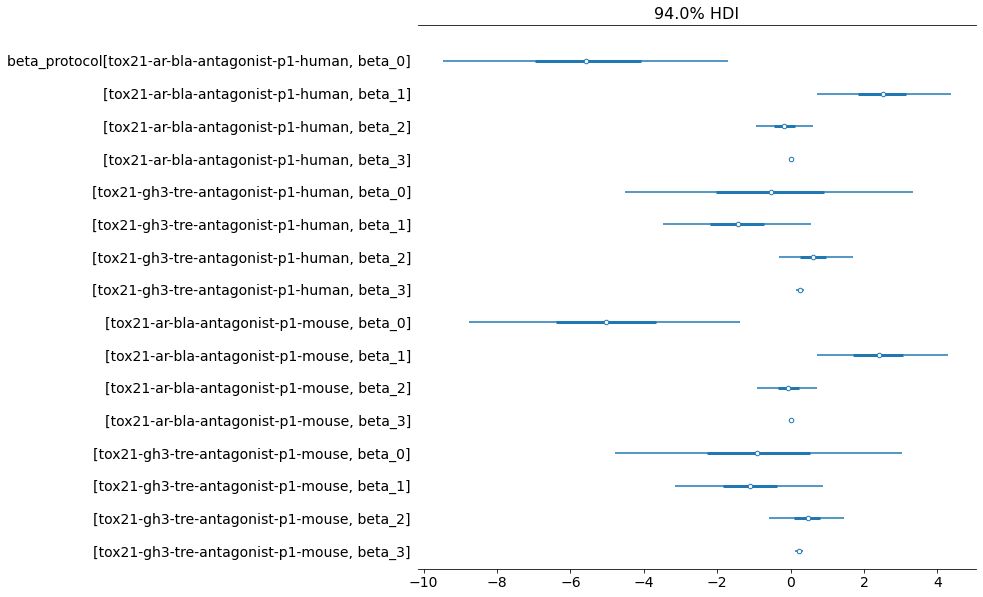

In [49]:
# Display results, error
import arviz as az
with assay_level_model:
    az.plot_forest(
        tr_assay,
        combined=True,
        var_names=["beta_protocol"],
        figsize=(10, 10),
        textsize=14,
    )

In [72]:
tr_assay

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [73]:
RANDOM_SEED = 10
with assay_level_model:
    tr_assay.extend(pm.sample_posterior_predictive(tr_assay))

/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_beta_0[0],-1.33,2.57,-6.04,3.59,0.11,0.08,573.94,488.93,1.01
g_beta_0[1],1.27,3.34,-4.88,7.50,0.14,0.11,611.24,500.94,1.01
beta_0[tox21-ar-bla-antagonist-p1-human],-4.56,2.47,-8.98,0.17,0.11,0.08,536.00,695.05,1.00
beta_0[tox21-gh3-tre-antagonist-p1-human],1.78,1.80,-1.45,4.95,0.08,0.06,640.12,434.21,1.01
beta_0[tox21-ar-bla-antagonist-p1-mouse],-0.18,1.09,-2.53,1.78,0.05,0.05,450.92,515.45,1.01
...,...,...,...,...,...,...,...,...,...
"chol_corr[3, 3]",1.00,0.00,1.00,1.00,0.00,0.00,1848.65,1939.98,1.00
chol_stds[0],1.41,1.24,0.12,3.72,0.08,0.05,276.26,303.69,1.02
chol_stds[1],1.16,1.13,0.08,3.30,0.10,0.07,107.83,69.78,1.05
chol_stds[2],0.85,0.71,0.06,2.05,0.05,0.03,232.49,306.23,1.01


In [127]:
# generate testing data
predictors_out_of_sample = X_test.copy()
predictors_out_of_sample.insert(0,'Intercept',1)
predictors_out_of_sample = np.asarray(predictors_out_of_sample, dtype='float64')
print(predictors_out_of_sample.shape)
outcomes_out_of_sample = y_test
print(outcomes_out_of_sample.shape)

(72215, 205)
(72215,)


In [7]:
RANDOM_SEED = 10
### generate sample for prediction
protocol_pred = pd.factorize(assay_info_test.ProtocolName)
    
prediction_coords = {
    'obs_id': np.arange(predictors_out_of_sample.shape[0]),
    'chem_descrip': np.arange(predictors_out_of_sample.shape[1]),
    'protocol':list(protocol_pred[1]),
    'params':['beta_{0}'.format(i) for i in range(predictors_out_of_sample.shape[1])]
}
with assay_level_model:
    pm.set_data(
        new_data = {"x": predictors_out_of_sample,
                    "protocol_idx": list(protocol_pred[0]),
                    "organism_idx": organisms,
                   "lambda_sig": lambdas}
    )

    posterior_predictive = pm.sample_posterior_predictive(
        tr_assay, var_names=["likelihood"], random_seed=RANDOM_SEED
    )


,Cell_Type,Gender,Organism,Tissue_Type2,ProtocolName
0,epithelial,F,Human,kidney,tox21-ar-bla-antagonist-p1
1,epithelial,F,Human,kidney,tox21-ar-bla-antagonist-p1
2,epithelial,F,Human,kidney,tox21-ar-bla-antagonist-p1
3,epithelial,F,Human,kidney,tox21-ar-bla-antagonist-p1
4,epithelial,F,Human,kidney,tox21-ar-bla-antagonist-p1
...,...,...,...,...,...
395,epithelial-like,M,Human,liver,tox21-ahr-p1
396,epithelial-like,M,Human,liver,tox21-ahr-p1
397,epithelial-like,M,Human,liver,tox21-ahr-p1
398,epithelial-like,M,Human,liver,tox21-ahr-p1


In [8]:
posterior_predictive.posterior_predictive['likelihood'].mean(('chain', 'draw'))
test_pred = pd.DataFrame(posterior_predictive.posterior_predictive['likelihood'].mean(('chain', 'draw')))
test_pred

,Cell_Type,Gender,Organism,Tissue_Type2,ProtocolName
count,400,400,400,400,400
unique,2,2,2,3,4
top,epithelial,F,Human,kidney,tox21-ar-bla-antagonist-p1
freq,300,300,300,200,100


In [9]:
y_test_r = y_test.replace('inactive', 0.0)
y_test_r = y_test_r.replace('active antagonist', 1.0)
y_test_r

inactive             200
active antagonist    200
Name: outcome, dtype: int64

In [10]:
print(metrics.classification_report(list(y_test_r), pd.DataFrame(test_pred).round()))
print('Balanced Accuracy Test')
print(metrics.balanced_accuracy_score(list(y_test_r), pd.DataFrame(test_pred).round()))

,BCUT2D_CHGHI,BCUT2D_MRLOW,Chi0,Chi0n,Chi1,Chi1v,Chi2v,Chi3v,EState_VSA3,EState_VSA6,...,fr_NH0,fr_aniline,fr_benzene,fr_halogen,fr_ketone,fr_nitro,fr_nitro_arom,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,2.196607,0.094717,16.420961,13.148500,10.602430,8.110878,6.458427,4.483895,12.164366,10.067100,...,0.947500,0.335000,1.055000,0.917500,0.107500,0.055000,0.047500,0.310000,0.305000,0.885000
std,0.235678,0.493623,10.971557,8.642877,7.070907,5.254578,4.461554,3.468107,15.253228,13.575286,...,1.195121,0.688447,1.146849,1.538379,0.395392,0.286671,0.265367,1.855399,1.850821,3.054521
min,1.240992,-1.998501,2.707107,1.985599,1.414214,0.813053,0.235702,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.041222,-0.140866,9.834481,7.765161,6.249010,4.652983,3.354264,2.021129,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.186193,-0.026859,14.214996,11.302755,9.422631,7.199927,5.629867,3.661637,6.792942,6.066367,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.336274,0.286054,19.801275,16.252219,13.096502,10.050510,8.289359,5.793819,17.627422,13.847474,...,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.303739,1.667832,89.381682,59.894417,57.351987,33.919614,26.092602,18.414814,121.327341,76.225885,...,7.000000,4.000000,10.000000,10.000000,3.000000,2.000000,2.000000,25.000000,25.000000,35.000000


In [11]:
print('AUCROC Test')
print(metrics.roc_auc_score(list(y_test_r), test_pred))

0      tox21-ar-bla-antagonist-p1
1      tox21-ar-bla-antagonist-p1
2      tox21-ar-bla-antagonist-p1
3      tox21-ar-bla-antagonist-p1
4      tox21-ar-bla-antagonist-p1
                  ...            
395                  tox21-ahr-p1
396                  tox21-ahr-p1
397                  tox21-ahr-p1
398                  tox21-ahr-p1
399                  tox21-ahr-p1
Name: ProtocolName, Length: 400, dtype: object